## How to Build a Content-Based Recommender System For Your Product ??

### Presenting users with the most relevant information is an important task for any product to fulfill. To do this properly, you need to be able to extract their preferences from your raw data. Here’s a framework for you to start doing that.

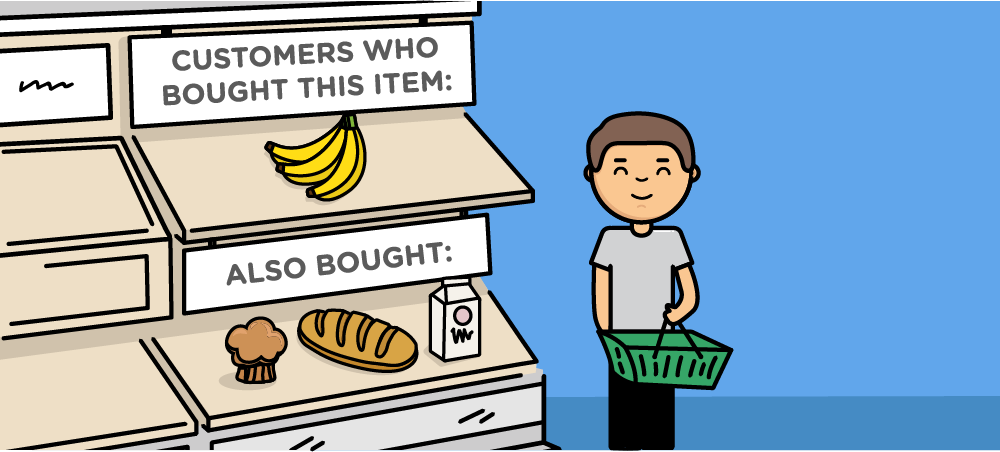

## Recommender systems
### There are two main data selection methods:

* ### Collaborative-filtering: In collaborative-filtering items are recommended, for example movies, based on how similar your user profile is to other users’, finds the users that are most similar to you and then recommends items that they have shown a preference for. This method suffers from the so-called cold-start problem: If there is a new movie, no-one else would’ve yet liked or watched it, so you’re not going to have this in your list of recommended movies, even if you’d love it.

* ### Content-based filtering: This method uses attributes of the content to recommend similar content. It doesn’t have a cold-start problem because it works through attributes or tags of the content, such as actors, genres or directors, so that new movies can be recommended right away.

### Based on this, I’m going to introduce you to content-based filtering for a movie recommender system. I’ll use Python as the programming language for the implementation.

In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [ ]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt

### Step 1: Choosing your data
* ### The first thing to do when starting a data science project is to decide what data sets are going to be relevant to your problem. This stage of the project is referred to as data selection and is highly important because if you choose the wrong data source, you won’t get successful performance.

In [ ]:
data = pd.read_csv('/kaggle/input/news-dataset-18920/result_final.csv')

In [ ]:
data.shape

In [ ]:
data.head()

* ### Data cleaning and selecting few columns we will be requiring for the recomendation--

In [ ]:
data = data.drop_duplicates(subset=None, keep='first', inplace=False)

In [ ]:
data.shape

In [ ]:
data.insert(0,'id',range(0,data.shape[0]))
data

In [ ]:
ds = data[['date','title','text','link']]

In [ ]:
ds.shape

In [ ]:
ds = ds.dropna()

In [ ]:
ds = ds.drop_duplicates(subset=None, keep='first', inplace=False)

In [ ]:
ds.insert(0,'id',range(0,ds.shape[0]))

In [ ]:
ds.shape

In [ ]:
ds.head()

## Step 2: Encoding your data
### There are a number of popular encoding schemes but the main ones are:

* ### One-hot encoding
* ### Term frequency–inverse document frequency (TF-IDF) encoding
* ### Word embeddings
### For our example, we will use the term frequency–inverse document frequency (TF-IDF) encoding scheme.

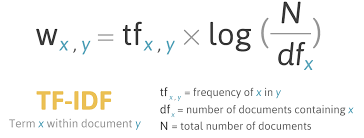


### The advantage of TF-IDF encoding is that it will weigh a term (a tag for a movie in our example) according to the importance of the term within the document: The more frequently the term appears, the larger its weight will be. At the same time, it weighs the item inversely to the frequency of this term across the entire dataset: It will emphasise terms that are relatively rare occurrences in the general dataset but of importance to the specific content at hand.

## Importing Liberaries

In [ ]:
from nltk.corpus import stopwords
from sklearn.metrics.pairwise import linear_kernel
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.tokenize import RegexpTokenizer
import re
import string
import random

## Applying all the functions in text column and storing as a cleaned_desc

In [ ]:
# Function for removing NonAscii characters
#def _removeNonAscii(s):
#    return "".join(i for i in s if  ord(i)<128)

# Function for converting into lower case
def make_lower_case(text):
    return text.lower()

# Function for removing stop words
def remove_stop_words(text):
    text = text.split()
    stops = set(stopwords.words("english"))
    text = [w for w in text if not w in stops]
    texts = [w for w in text if w.isalpha()]
    texts = " ".join(texts)
    return texts

# Function for removing punctuation
def remove_punctuation(text):
    tokenizer = RegexpTokenizer(r'\w+')
    text = tokenizer.tokenize(text)
    text = " ".join(text)
    return text

# Function for removing the html tags
def remove_html(text):
    html_pattern = re.compile('<.*?>')
    return html_pattern.sub(r'', text)

# Applying all the functions in description and storing as a cleaned_desc
#ds['cleaned_desc'] = ds['text'].apply(_removeNonAscii)
ds['cleaned_desc'] = ds['text'].apply(func = make_lower_case)
ds['cleaned_desc'] = ds.cleaned_desc.apply(func = remove_stop_words)
ds['cleaned_desc'] = ds.cleaned_desc.apply(func=remove_punctuation)
ds['cleaned_desc'] = ds.cleaned_desc.apply(func=remove_html)

In [ ]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import linear_kernel

## analyzer -- to select individual words# default 
## max_df[0.0,1.0] - used to ignore words with frequency more than 0.8 these words can be useless words as these words may appear only once and may not have a significant meaning
## min_df -- similar reason as the above one. 
## use_idfbool, default=True  -- Enable inverse-document-frequency reweighting.

tf = TfidfVectorizer(analyzer='word',stop_words='english',max_df=0.8,min_df=0.0,use_idf=True,ngram_range=(1,3))
tfidf_matrix = tf.fit_transform(ds['cleaned_desc'])

### This is how a tfidf vector looks like. 

In [ ]:
pd.DataFrame(tfidf_matrix.toarray(), columns=tf.get_feature_names())

### <i>Now, we have a representation of every item in terms of its description. Next, we need to calculate the relevance or similarity of one document to another.</i>

## Vector Space Model
* ### In this model, each item is stored as a vector of its attributes (which are also vectors) in an n-dimensional space, and the angles between the vectors are calculated to determine the similarity between the vectors.


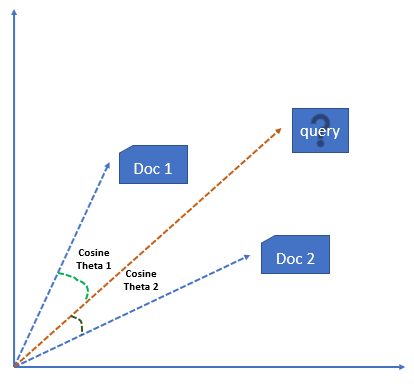

* ### The method of calculating the user’s likes / dislikes / measures is calculated by taking the cosine of the angle between the user profile vector (Ui ) and the document vector; or in our case, the angle between two document vectors.
* ### The ultimate reason behind using cosine is that the value of cosine will increase as the angle between vectors with decreases, which signifies more similarity.

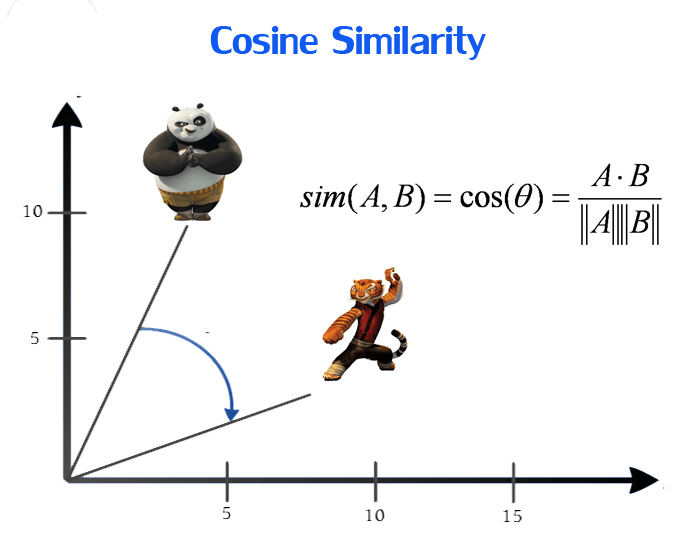

In [ ]:
cosine_similarities = linear_kernel(tfidf_matrix, tfidf_matrix)

In [ ]:
results = {}
for idx, row in ds.iterrows():
    similar_indices = cosine_similarities[idx].argsort()[:-100:-1]
    similar_items = [(cosine_similarities[idx][i], ds['id'][i]) for i in similar_indices]
    results[row['id']] = similar_items[1:]
print('done!')


In [ ]:
similar_indices[:100]

In [ ]:

def item(id):
    return ds.loc[ds['id'] == id]['title'].tolist()[0].split(' - ')[0]

# Just reads the results out of the dictionary.
def recommend(item_id, num):
    print("Recommending " + str(num) + " products similar to " + item(item_id) + "...")
    print("-------")
    recs = results[item_id][:num]
    for rec in recs:
        print("Recommended : " + item(rec[1]) + " (score:" + str(rec[0]) + ")",end='\n\n')

recommend(item_id=10, num=15)

In [ ]:
cosine_similarities

### A recommender system has to decide between two methods for information delivery when providing the user with recommendations:
* ### Exploitation. The system chooses documents similar to those for which the user has already expressed a preference.
* ### Exploration. The system chooses documents where the user profile does not provide evidence to predict the user’s reaction.<br><br>
### <b>We are going to use <u>Exploitation method </u></b>

In [ ]:
def recomendation(idx,no_of_news_article):
    #get similarity values with other articles
    similarity_score = list(enumerate(cosine_similarities[idx]))
    similarity_score = sorted(similarity_score, key=lambda x: x[1], reverse=True)
    # Get the scores of the n most similar news articles. Ignore the first movie.
    similarity_score = similarity_score[1:no_of_news_article+1]
    
    print("Article Read -- " + ds['title'].iloc[idx] +" link --"+ ds['link'].iloc[idx])
    print(" ---------------------------------------------------------- ")
    news_indices = [i[0] for i in similarity_score]
    for i in range(len(news_indices)):
        print("Recomendation "+ str(i+1)+" --- " +str(news_indices[i])+"(IDX)  "+str(ds['date'].iloc[news_indices[i]])+" : "+
              ds['title'].iloc[news_indices[i]] +" || Link --"+ ds['link'].iloc[news_indices[i]] +" score -- "+ str(similarity_score[i][1]))
        print()

## Test 1 - when min_df=0.2 shape 1496 rows × 31 columns

In [ ]:
idx=3  #min_df=0.2 shape 1496 rows × 31 columns
no_of_news_article=10
recomendation(idx,no_of_news_article)

## Test 2 - when min_df=0.1 shape 1496 rows × 144 columns

In [ ]:
idx=3   #min_df=0.1  shape 1496 rows × 144 columns
no_of_news_article=10
recomendation(idx,no_of_news_article)

## Test 3 - when min_df=0.0 shape 1496 rows × 588777 columns

In [ ]:
idx=3  #min_df=0.0 shape 1496 rows × 588777 columns
no_of_news_article=10
recomendation(idx,no_of_news_article)

### So When the size of the corpous is very large the similarity score decreases but predicitions are much better. And the score decreses because of regulersation there for nid_df - 0.0 was better in this case. 
### However this is not true every time. 

In [ ]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

## analyzer -- to select individual words# default 
## max_df[0.0,1.0] - used to ignore words with frequency more than 0.8 these words can be useless words as these words may appear only once and may not have a significant meaning
## min_df -- similar reason as the above one. 
## use_idfbool, default=True  -- Enable inverse-document-frequency reweighting.

tf = TfidfVectorizer(analyzer='word',stop_words='english',max_df=0.8,min_df=0.0,use_idf=True,ngram_range=(1,3))
tfidf_matrix = tf.fit_transform(ds['cleaned_desc'])

In [ ]:
cosine_similarities = cosine_similarity(tfidf_matrix, tfidf_matrix)

In [ ]:
idx=3  #min_df=0.0 shape 1496 rows × 31 columns
no_of_news_article=10
recomendation(idx,no_of_news_article)

## So what have we done till now -- 
* ### We have implemented vector space method to map the documents where the tfidf -> first maps doc X words matrix .. 
* ### Then  we have found cosine similarity between the documents similar to  Singular Vector Decomposition where we have found the relation of documents with other's on the bases of text the other documents have and recommended the top n articles he may like

## Conclusion -- 

### We have succesfully created a recomendation system but this may not the that efficient for a very large corpous thus we will try to implement a probablistic model for the same.

### Note: we wil not be using Latent semantic Analysis as we do not want to find any kighlighting words in the corpous rather find a relation between one so instead of LSA we are going  for topic modelling for a change to see if it works.. 
### We are goning to see LDA and LSH for this process.

In [ ]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

## analyzer -- to select individual words# default 
## max_df[0.0,1.0] - used to ignore words with frequency more than 0.8 these words can be useless words as these words may appear only once and may not have a significant meaning
## min_df -- similar reason as the above one. 
## use_idfbool, default=True  -- Enable inverse-document-frequency re-weighting.

tf = TfidfVectorizer(analyzer='word',stop_words='english',max_df=0.8,min_df=0.1,use_idf=False,ngram_range=(1,3))
tfidf_matrix = tf.fit_transform(ds['cleaned_desc'])
cosine_similarities = cosine_similarity(tfidf_matrix, tfidf_matrix)

In [ ]:
pd.DataFrame(tfidf_matrix.toarray(), columns=tf.get_feature_names())

In [ ]:
idx=3  #min_df=0.0 shape 1496 rows × 31 columns
no_of_news_article=10
recomendation(idx,no_of_news_article)

* seeing a significant change in the similarity score as it has not been L2 regulerised. 

In [ ]:
from sklearn.cluster import KMeans

num_clusters = 5

km = KMeans(n_clusters=num_clusters)

%time km.fit(tfidf_matrix)

clusters = km.labels_.tolist()

In [ ]:
ds.insert(2,'cluster',clusters)

#ds.insert(0,'id',range(0,ds.shape[0]))

In [ ]:
ds.head()

In [ ]:
ds['cluster'].value_counts()

In [ ]:
from scipy.cluster.hierarchy import ward, dendrogram
from sklearn.metrics.pairwise import cosine_similarity
dist = 1 - cosine_similarity(tfidf_matrix)

linkage_matrix = ward(dist) #define the linkage_matrix using ward clustering pre-computed distances

fig, ax = plt.subplots(figsize=(15, 200)) # set size
ax = dendrogram(linkage_matrix)

plt.tick_params(\
    axis= 'x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom='off',      # ticks along the bottom edge are off
    top='off',         # ticks along the top edge are off
    labelbottom='off',
               width=10000)

plt.tight_layout() #show plot with tight layout


In [ ]:
## Implementing Topic modelling -- LSH 